# Simulate Reads

How many reads do we need to detect N clusters at varying levels of abundance with varying number of modifications present.

Variables:
* Number of read classes
* Number of reads in each class
* Similarity to other read classes aka How many modification sites differ
* What is the accuracy for each modification

Thoughts / Sticking points:

Some mods are not independent so how do we model non-independent mods? Include them and just forget about it? Map them together into a single mod? Exclude from analysis? How do we determine if a cluster is "Good". What clustering algorithm should we use? Can we generate several simulations and then see which clustering algorithm does best? I think yes. 


1: Generate random reads profiles from mod profile and prediction accuracy  
2: Create Simulation Framework

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.cluster import DBSCAN
import umap
import hdbscan
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

from read_clustering.variant_call import VariantCalls
threshold = 0.5
np.random.seed(42)

/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")
/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def generate_call_from_fraction_correct(label, fraction_correct, n=1):
    p = np.random.random(n)
    if label:
        return (p <= fraction_correct).astype(int)
    else:
        return (p > fraction_correct).astype(int)

def generate_call_from_sample_of_probs(sampling_of_probs, n=1):
    return np.random.choice(sampling_of_probs, n)    

In [3]:
print(np.average(generate_call_from_fraction_correct(1, 0.1, 10000)))
print(np.average(generate_call_from_fraction_correct(0, 0.9, 10000)))

0.1031
0.1021


In [4]:
dist = generate_call_from_fraction_correct(1, 0.1, 10000)
print(np.average(dist))
print(np.average(generate_call_from_sample_of_probs(dist, 10000)))

0.0998
0.103


In [5]:
accuracy_csv = "/Users/andrewbailey/Desktop/1_per_position_data_0.5.csv"
accuracy_csv = "/Volumes/gdrive/rrna_kube_testing/small_5mer/test/train_500_test_500_prob_0.7_em_iterations_30_gaussian_true_FREQ_THRESHOLD_0_USE_IVT_TRAINING_true_unsupervised_false_all_kmers_false_small_model_5mer_use_median_true/testing_accuracy_csvs/30_per_position_data_0.5.csv"
accuracy_csv = "/Users/andrewbailey/CLionProjects/read_clustering/30_per_position_data_0.5.csv"
# accuracy_csv = "/Users/andrewbailey/CLionProjects/rrna_analysis/notebooks/rrna_data/rrna_kube_testing/small_5mer/depletion/train_500_test_500_prob_0.7_em_iterations_30_gaussian_true_FREQ_THRESHOLD_0_USE_IVT_TRAINING_true_unsupervised_false_all_kmers_false_small_model_5mer_use_median_true_min_sd_0/training_accuracy_csvs/30_per_position_data_0.5.csv"

In [6]:
accuracy_data = pd.read_csv(accuracy_csv)


In [7]:
accuracy_data = pd.read_csv(accuracy_csv)
acc_df = accuracy_data[["contig", "reference_index", "strand"]]
index = pd.MultiIndex.from_frame(acc_df)
mod_map = [1 for x in range(len(acc_df)-3)] + [0, 0, 0]
accuracy_key = "accuracy"
n=10

In [8]:
mod_calls = []
for i, x in enumerate(mod_map):
    key = "recall"
    if x == 0:
        key = "specificity"
    mod_calls.append(generate_call_from_fraction_correct(x, accuracy_data[key][i], n))
data = np.array(mod_calls)


In [9]:
data

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [10]:
class SimulateModProbs(object):
    def __init__(self, accuracy_csv):
        self.accuracy_data = pd.read_csv(accuracy_csv)
        self.acc_df = self.accuracy_data[["contig", "reference_index", "strand"]]
        self.index = pd.MultiIndex.from_frame(self.acc_df)

#     def get_simulated_data(self, mod_map, accuracy_key="accuracy", n=100):
#         mod_accuracy_map = zip(mod_map, accuracy_data[accuracy_key])
#         data = np.array([generate_call_from_fraction_correct(mod, accuracy, n) for mod, accuracy in mod_accuracy_map])
#         return pd.DataFrame(data.T, columns=self.index)
    
    def get_simulated_data(self, mod_map, n=100):
        mod_calls = []
        for i, x in enumerate(mod_map):
            key = "recall"
            if x == 0:
                key = "specificity"
            mod_calls.append(generate_call_from_fraction_correct(x, self.accuracy_data[key][i], n))
        return pd.DataFrame(np.array(mod_calls).T, columns=self.index) 

    
    def generate_variant_calling_output(self, mod_map, accuracy_key="accuracy", n=100):
        df = self.get_simulated_data(mod_map, n=n)
        df.index.rename("read_id", inplace=True)
        df1 = df.melt(ignore_index=False)
        df1.rename(columns={"value": "prob2"}, inplace=True)
        df1.loc[:, "prob1"] = 1-df1["prob2"]
        df1.loc[:, "variants"] = "ab"
        df1.reset_index(inplace=True)
        return df1

In [11]:
simulation_path = "/Users/andrewbailey/CLionProjects/read_clustering/data/simulation/test"
smp = SimulateModProbs(accuracy_csv)

In [12]:
n = 1000
mod_map = [1 for x in range(len(smp.acc_df))]
df1 = smp.generate_variant_calling_output(mod_map, n=n)
out_path = os.path.join(simulation_path, "test.csv")
df1.to_csv(out_path, index=False)

In [13]:
n = 1000
mod_map2 = [0 if x in [ 8] else 1 for x in range(len(smp.acc_df))]
df1 = smp.generate_variant_calling_output(mod_map2, n=n)
out_path2 = os.path.join(simulation_path, "test2.csv")
df1.to_csv(out_path2, index=False)

In [14]:
n = 1000
mod_map2 = [0 if x in [ 15] else 1 for x in range(len(smp.acc_df))]
df1 = smp.generate_variant_calling_output(mod_map2, n=n)
out_path3 = os.path.join(simulation_path, "test3.csv")
df1.to_csv(out_path3, index=False)
n = 1000
mod_map2 = [0 if x in [ 28, 29] else 1 for x in range(len(smp.acc_df))]
df1 = smp.generate_variant_calling_output(mod_map2, n=n)
out_path4 = os.path.join(simulation_path, "test4.csv")
df1.to_csv(out_path4, index=False)

In [15]:
ivt_path = "/Users/andrewbailey/CLionProjects/read_clustering/data/inference/variant_calls/canonical_ivt_round30_alt_canonical_supervised_500_500.model.csv"
cbf5_glu_psu_depletion_path = "/Users/andrewbailey/CLionProjects/read_clustering/data/inference/variant_calls/depletion_cbf5_glu_round30_alt_canonical_supervised_500_500.model.csv"
nop58_glu_2o_depletion_path = "/Users/andrewbailey/CLionProjects/read_clustering/data/inference/variant_calls/depletion_nop58_glu_round30_alt_canonical_supervised_500_500.model.csv"       
native_cbf5_gal_path = "/Users/andrewbailey/CLionProjects/read_clustering/data/inference/variant_calls/native_cbf5_gal_round30_alt_canonical_supervised_500_500.model.csv"
native_nop58_gal_path = "/Users/andrewbailey/CLionProjects/read_clustering/data/inference/variant_calls/native_nop58_gal_round30_alt_canonical_supervised_500_500.model.csv"

file_paths = [out_path2]
labels = ["one_off"]

file_paths = [out_path, out_path2, out_path3, out_path4]
labels = ["test", "one_off1", "one_off2", "one_off3"]
# file_paths = [out_path2, out_path3, out_path4]
# labels = ["one_off1", "one_off2", "one_off3"]

# file_paths = [ivt_path, cbf5_glu_psu_depletion_path, nop58_glu_2o_depletion_path, native_cbf5_gal_path, native_nop58_gal_path]
# labels = ["ivt", "cbf5_glu_psu_depletion", "nop58_glu_2o_depletion", "native_cbf5_gal", "native_nop58_gal"]

In [16]:
vc = VariantCalls(file_paths, labels)


In [21]:
len(vc.get_X("RDN25-1", vc.get_contig_positions("RDN25-1")))

4000

In [20]:
len(vc.get_X("RDN18-1", vc.get_contig_positions("RDN18-1")))

4000

In [18]:
contig = 'RDN18-1'
# n_components = 2
# save_fig_path=None
# vc.plot_UMAP_by_label(contig, vc.get_contig_positions(contig), n_components=n_components, figure_path=save_fig_path)

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


ValueError: The condensed distance matrix must contain only finite values.

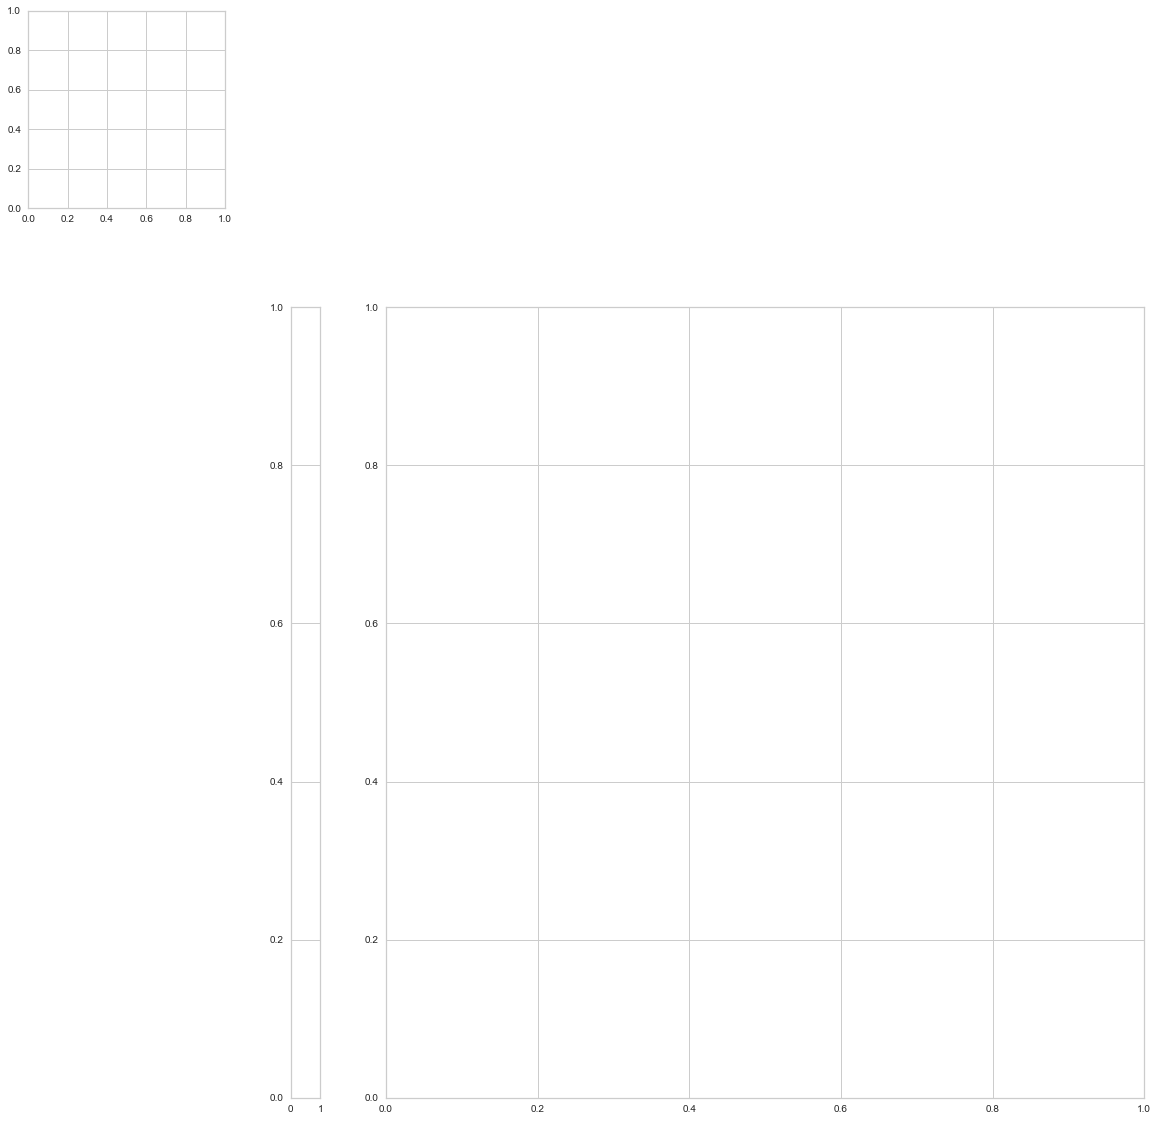

In [19]:
n=-1
figure_path = None
method = 'average'
# method = "centroid"
# method = "complete"
# method = "weighted"
# metric = "braycurtis"
# metric = "cityblock"
metric = 'euclidean'
metric = 'correlation'

# positions = [435, 758, 1289, 1414]
positions = vc.get_contig_positions(contig)
vc.plot_heatmap_dendrogram(contig, positions, n=n, figure_path=figure_path,
                          metric=metric,
                          col_cluster=False,
                          row_cluster=True,
                           method=method)


In [34]:
cmap = "OrRd"
cmap = "cool"
cmap = "hot"
cmap = "Blues"

pseudou="ql"
twoprimeo=["na", "ob", "pc", "qd"]
norm = None
stat = "r2"


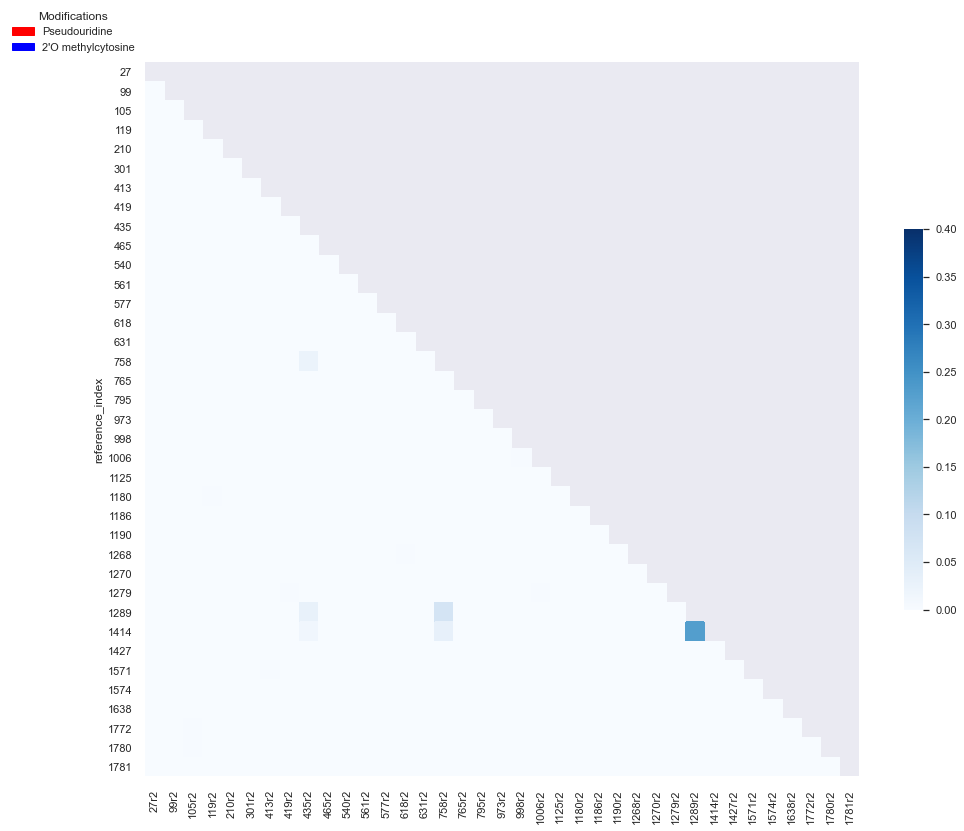

In [35]:
contig = 'RDN18-1'
ld_df = vc.plot_ld_heatmap(contig, vc.get_contig_positions(contig), stat="r2", cmap=cmap, norm=norm)


In [21]:
simulation_path = "/Users/andrewbailey/CLionProjects/read_clustering/data/simulation/test"
smp = SimulateModProbs(accuracy_csv)


In [22]:
data_frames = []
label_map = {}
#             [1 for x in range(len(smp.acc_df))],

mod_maps = [[0 if x in [] else 1 for x in range(len(smp.acc_df))],
            [0 if x in [ 6] else 1 for x in range(len(smp.acc_df))],
            [0 if x in [ 7] else 1 for x in range(len(smp.acc_df))],
            [0 if x in [ 8] else 1 for x in range(len(smp.acc_df))]
           ]
names = [
        "test1", 
        "test2",
        "test3",
        "test4"]
counts = [
         1000, 
         1000,
         1000,
         1000]
for i, (mod_map, name, n) in enumerate(zip(mod_maps, names, counts)):
    d0 = smp.get_simulated_data(mod_map, n=n)
    d0["label"] = name
    label_map[name] = i
    data_frames.append(d0)


In [23]:
final_df = pd.concat(data_frames, ignore_index=True)
labels_true = final_df["label"].map(label_map)

In [24]:
X = final_df["RDN18-1"]

In [25]:
set(labels_true)

{0, 1, 2, 3}

In [26]:
reducer = umap.UMAP()
umap_results = reducer.fit_transform(X)


KeyboardInterrupt: 

In [ ]:
# X = umap_results

In [ ]:
# #############################################################################
# # Compute DBSCAN
# db = DBSCAN(eps=3, min_samples=10).fit(X)
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
# labels = db.labels_
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise_ = list(labels).count(-1)


In [ ]:
# kmeans = KMeans(n_clusters=2, random_state=0)
# kmeans.fit(X)
# labels = db.labels_
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise_ = list(labels).count(-1)
# n_corepoints = len(X) - n_noise_


In [ ]:
# #############################################################################
# Compute HDBSCAN
db = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=1, metric='euclidean')
db.fit(X)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
n_corepoints = len(X) - n_noise_
# hdbscan.dist_metrics.METRIC_MAPPING


In [ ]:
print(set(labels))

In [ ]:
labels

In [ ]:
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print('Estimated number of clustered points: %d' % n_corepoints)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))


In [ ]:
%matplotlib notebook
# Plot result
plt.figure(figsize=(10,10))
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = umap_results[class_member_mask]
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markersize=3, alpha=0.25)

    else:
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markersize=3, alpha=0.9)

# colors2 = [plt.cm.Set1(each)
#       for each in np.linspace(0, 1, len(set(labels_true)))]
# unique_labels = set(labels_true)
# for k, col in zip(unique_labels, colors):
#     print(col)

#     true_label_mask = (labels_true == k)
#     xy = umap_results[true_label_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col2), markersize=5, alpha=1)
    

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()



In [ ]:
db.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))


Given an expectation of accuracy given certain breakdowns of reads, can we determine the true modification profiles of certain reads?

The clustering methods work if there are clear differences between the subclasses but clustering has no prior. We actually have information which will allow us to help determine subclusters of reads in other experiments.



In [46]:
smp = SimulateModProbs(accuracy_csv)


In [332]:
data_frames = []
label_map = {}
#             [1 for x in range(len(smp.acc_df))],

mod_maps = [[0 if x in [] else 1 for x in range(len(smp.acc_df))],
            [0 if x in [] else 1 for x in range(len(smp.acc_df))],
            [1 if x in [] else 0 for x in range(len(smp.acc_df))],
            [0 if x in [] else 1 for x in range(len(smp.acc_df))]
           ]
names = [
        "test1", 
        "test2",
        "test3",
        "test4"]
counts = [
         1000, 
         1000,
         100,
         1000]

# mod_maps = [[0 if x in [] else 1 for x in range(len(smp.acc_df))],
#             [0 if x in [ 6] else 1 for x in range(len(smp.acc_df))],
#             [0 if x in [ 7] else 1 for x in range(len(smp.acc_df))],
#             [0 if x in [ 8] else 1 for x in range(len(smp.acc_df))],
#             [0 if x in [ 8, 9] else 1 for x in range(len(smp.acc_df))]
#            ]
# names = [
#         "test1", 
#         "test2",
#         "test3",
#         "test4",
#         "test5"]
# counts = [
#          500, 
#          500,
#          500,
#          500,
#          500]

out_paths = []
for i, (mod_map, name, n) in enumerate(zip(mod_maps, names, counts)):
    d0 = smp.get_simulated_data(mod_map, n=n)
    df1 = smp.generate_variant_calling_output(mod_map2, n=n)
    out_path = os.path.join(simulation_path, f"test{i}.csv")
    df1.to_csv(out_path, index=False)
    out_paths.append(out_path)
    d0["label"] = name
    label_map[name] = i
    data_frames.append(d0)


In [333]:
final_df = pd.concat(data_frames, ignore_index=True)
labels_true = final_df["label"].map(label_map)
contig = "RDN18-1"


In [334]:
X = final_df[contig]
contig_acc = smp.accuracy_data[smp.accuracy_data["contig"] == contig]

In [335]:
contig_acc[contig_acc["reference_index"] == 27]["accuracy"]

0    0.9664
Name: accuracy, dtype: float64

In [336]:
total_prob = 1
for i, column in enumerate(X.columns):
    total_prob *= contig_acc[contig_acc["reference_index"] == column[0]]["recall"].iloc[0]
    if i == 0:
        a = X[column]
        continue
    a = a & X[column]
    

In [337]:
total_prob * len(X)

12.945083828891573

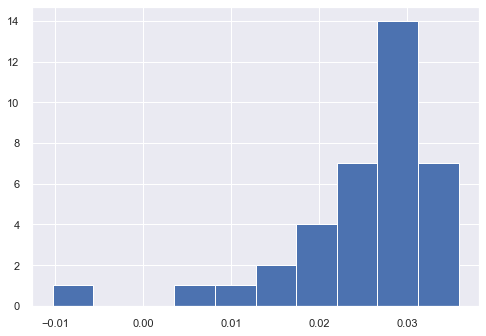

In [338]:
diff = contig_acc["recall"] - np.mean(X).values
diff.sort_values(ascending=False).hist()
hits = diff[np.abs(diff) > .05]
diff_mod_pos = hits.index.values

In [339]:
diff_mod_pos

array([], dtype=int64)

In [340]:

possible_groups = set()
for x in diff_mod_pos:
    print(f"first order: {x}")
    
    diff = contig_acc["recall"] - np.mean(X[X.iloc[:, x] < 0.5]).values
    hits = diff[np.abs(diff) > .20]
    print(f"hits: {hits.index.values}")
    possible_groups.add(frozenset(hits.index.values))
#     
    diff = contig_acc["recall"] - np.mean(X[X.iloc[:, x] >= 0.5]).values
    hits = diff[np.abs(diff) > .20]
    for x in hits.index.values:
        if x not in diff_mod_pos: 
            print(f"oppo hits: {x}")


In [341]:
for group in possible_groups:
    print(f"Group: {group}")
    mask = len(X) * [True]
    for x in group:
        mask = mask & X.iloc[:, x] < 0.5
    diff = contig_acc["recall"] - np.mean(X[mask]).values
    hits = diff[np.abs(diff) > .20]
    for x in hits.index.values:
        if x not in diff_mod_pos:
            print(f"hits: {hits.index.values}")


# GETTING OUTLIERS

In [342]:
from itertools import combinations
from scipy import stats


In [364]:
def get_joint_marginal(X, group):
    bool_mask = X.iloc[:, group[0]] > 0.5
    p_of_each_mod = [np.sum(X.iloc[:, group[0]] > 0.5) / len(X)]
    for x in group[1:]:
        bool_mask &= X.iloc[:, x] > 0.5
        p_of_each_mod.append(np.sum(X.iloc[:, x] > 0.5) / len(X))
    joint_prob = np.mean(bool_mask)
    marginal_prob_product = np.prod(p_of_each_mod)
    return joint_prob, marginal_prob_product


In [373]:

def get_joint_marginal_diffs(X, options, n):
    diffs = []
    for group in combinations(options, n):

        #     print(f"joint prob, {joint_prob}")
        #     print(f"marginal prob product, {np.prod(p_of_each_mod)}")
        joint_prob, marginal_prob_product = get_joint_marginal(X, group)
        diff = joint_prob - marginal_prob_product
        diffs.append([group, diff])
    diffs = pd.DataFrame(diffs)
    return diffs

diffs = get_joint_marginal_diffs(X, list(range(len(X.columns))), 2)


            0         1
533  (20, 24)  0.029511
373  (12, 20)  0.029486
293   (9, 15)  0.029001
328  (10, 24)  0.028967
324  (10, 20)  0.028960
309   (9, 31)  0.028517
11    (0, 12)  0.028481
537  (20, 28)  0.028466
316  (10, 12)  0.028399
290   (9, 12)  0.028239
591  (24, 28)  0.028195
54    (1, 20)  0.028115
377  (12, 24)  0.028006
319  (10, 15)  0.027976
332  (10, 28)  0.027954
9     (0, 10)  0.027865
370  (12, 17)  0.027857
443  (15, 24)  0.027752
540  (20, 31)  0.027745
321  (10, 17)  0.027728
298   (9, 20)  0.027724
594  (24, 31)  0.027720
204   (6, 10)  0.027611
1      (0, 2)  0.027571
368  (12, 15)  0.027536
206   (6, 12)  0.027502
214   (6, 20)  0.027490
381  (12, 28)  0.027454
19    (0, 20)  0.027380
439  (15, 20)  0.027209
366  (12, 13)  0.027198
478  (17, 20)  0.027160
43     (1, 9)  0.027114
317  (10, 13)  0.027066
302   (9, 24)  0.027043
8      (0, 9)  0.027007
482  (17, 24)  0.026969
16    (0, 17)  0.026928
46    (1, 12)  0.026904
447  (15, 28)  0.026725
384  (12, 31)  0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a232e2e90>]],
      dtype=object)

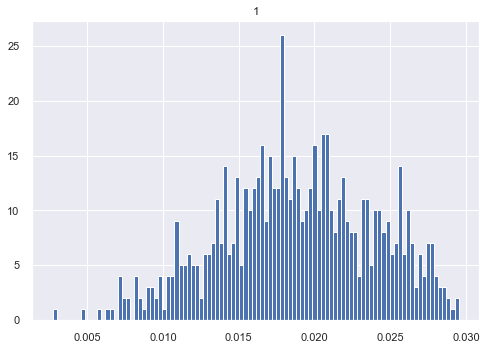

In [374]:
pd.set_option('display.max_rows', None)
sorted_diffs = diffs.sort_values(by=[1],axis=0, ascending=False)
print(sorted_diffs)
pd.set_option('display.max_rows', 10)
sorted_diffs.hist(bins=100)


In [375]:
og_scores = sorted_diffs.iloc[:, 1]
pos_targets = sorted_diffs[(stats.zmap(sorted_diffs.iloc[:, 1], og_scores) > 2.5)]
sets = [set(x) for x in (pos_targets.iloc[:, 0])]
if len(sets) == 0:
    pos_options = {}
else:
    pos_options = set.union(*sets)

    
neg_targets = sorted_diffs[(stats.zmap(sorted_diffs.iloc[:, 1], og_scores) < -2.5)]

sets = [set(x) for x in (neg_targets.iloc[:, 0])]
if len(sets) == 0:
    neg_options = {}
else:
    neg_options = set.union(*sets)


print(pos_options, neg_options)

{} {3, 21, 11, 27}


          0         1
1   (3, 11)  0.014236
0   (3, 21)  0.012702
3  (21, 11)  0.010391
2   (3, 27)  0.005858
4  (21, 27)  0.004619
5  (11, 27)  0.002729


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a271abb50>]],
      dtype=object)

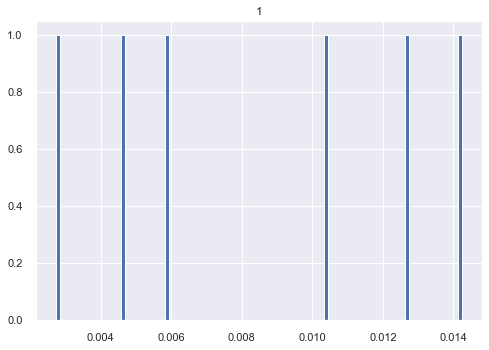

In [376]:
diffs = get_joint_marginal_diffs(X, neg_options, 2)
pd.set_option('display.max_rows', None)
sorted_diffs = diffs.sort_values(by=[1],axis=0, ascending=False)
print(sorted_diffs)
pd.set_option('display.max_rows', 10)
sorted_diffs.hist(bins=100)
